In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scripts.gokarts_race as kart_race

## Data Ingestion

In [2]:
race = kart_race.Race()
df = race.get_race_results()

## Data Visualization

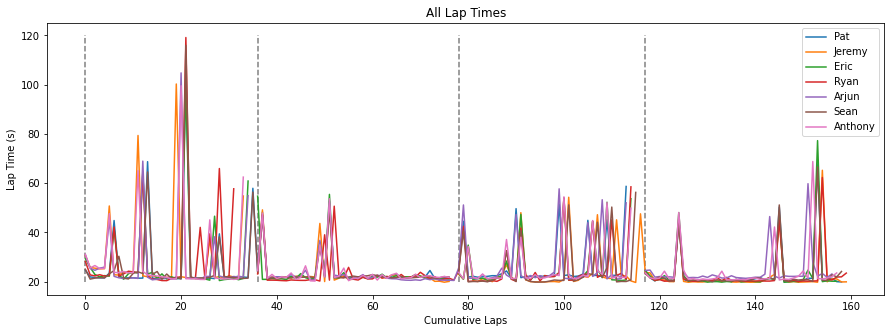

In [3]:
df.drop(columns=['Race Number', 'Lap']).plot(figsize=(15,5))
plt.title('All Lap Times')
plt.xlabel('Cumulative Laps')
plt.ylabel('Lap Time (s)')

start_new_race_laps = [0, 36, 78, 117]
plt.vlines(x=start_new_race_laps, ymin=20, ymax=120, linestyles='--', colors='Grey')

plt.show()

Lap times are mostly low 20s, but due to the race being stopped for crashes there are many much slower laps.

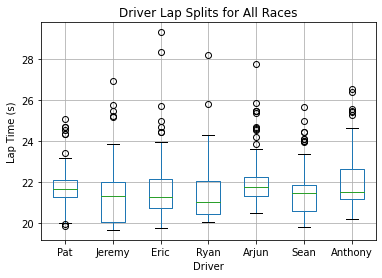

In [4]:
df.drop(columns=['Race Number', 'Lap'])[df<30].boxplot()
plt.title('Driver Lap Splits for All Races')
plt.ylabel('Lap Time (s)')
plt.xlabel('Driver')
plt.show()

Drivers have variance of 1-2s on most laps. The drivers that have more 20s lap times tending to have higher variance, likely due to getting stuck behind slower drivers.

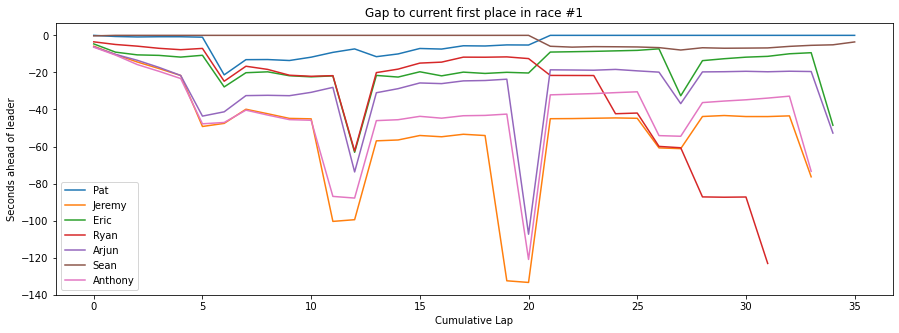

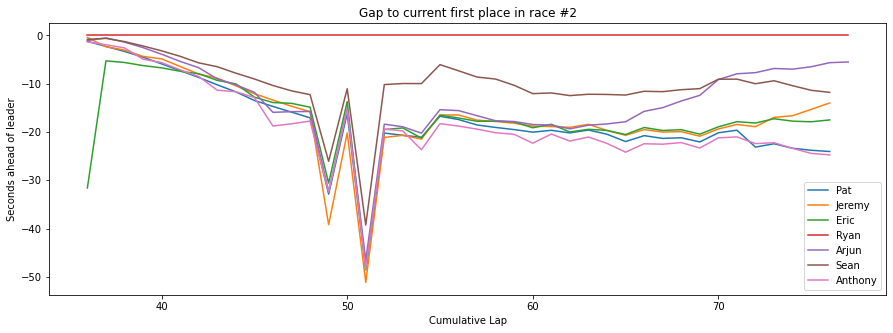

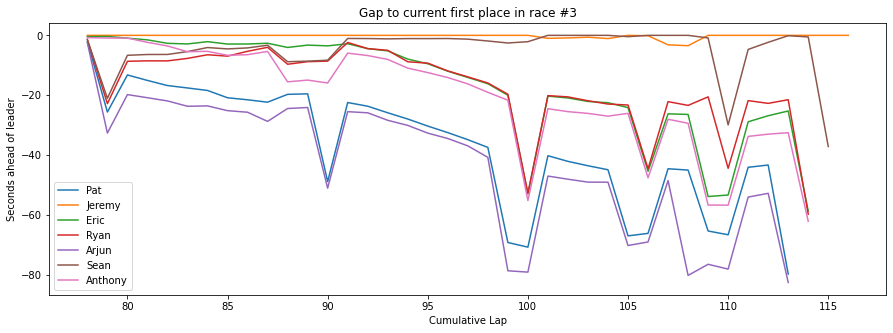

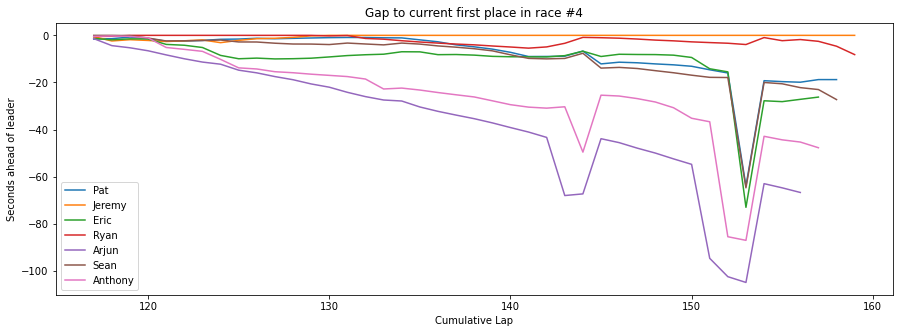

In [5]:
gaps = []

for race_number in race.race_numbers:
    race_results = df[df['Race Number']==race_number].drop(columns=['Race Number', 'Lap'])
    gap = pd.DataFrame(index=race_results.index, columns=race_results.columns)
    for index, row in race_results.iterrows():
        gap.loc[index] = race_results.cumsum().loc[index].min()-race_results.cumsum().loc[index]

    gap.plot(figsize=(15,5))
    plt.title('Gap to current first place in race #' + str(race_number))
    plt.xlabel('Cumulative Lap')
    plt.ylabel('Seconds ahead of leader')
    gaps.append(gap)

Drivers can get stuck behind slower karts or defensive drivers as seen by the overlapping lines typically being slower (negative sloper) than the leader. Drivers that are lapped slow down drivers as seen by similar patterns of 20s offset lines.

## Scoring
### Driver Scoring

In [6]:
race.get_race_ranking_summary_table()

,Mario Kart Points,F1 Race Points,F1 Sprint Points
Jeremy,46.0,70.0,24.0
Sean,43.0,63.0,25.0
Ryan,42.0,61.0,22.0
Pat,39.0,56.0,20.0
Eric,36.0,50.0,20.0
Arjun,33.0,42.0,16.0
Anthony,29.0,34.0,13.0


In [7]:
race.get_fastest_lap_ranking_summary_table()

,Mario Kart Points,F1 Race Points,F1 Sprint Points
Jeremy,48.0,74.0,25.0
Eric,44.0,65.0,24.0
Ryan,43.0,65.0,24.0
Sean,36.0,48.0,19.0
Anthony,35.0,46.0,18.0
Arjun,33.0,43.0,17.0
Pat,29.0,35.0,13.0


In [8]:
race.get_fastest_lap().mean().sort_values()

Jeremy     20.09050
Ryan       20.18925
Eric       20.35825
Sean       20.48050
Anthony    20.72000
Arjun      20.88975
Pat        20.99200
dtype: float64

In [9]:
race.get_fastest_lap().min()

Pat        19.855
Jeremy     19.657
Eric       19.729
Ryan       20.062
Arjun      20.465
Sean         19.8
Anthony    20.214
dtype: object

### Kart Scoring

In [10]:
race.get_kart_numbers()

,Pat,Jeremy,Eric,Ryan,Arjun,Sean,Anthony
Race,,,,,,,
1,7,10,21,3,1,4,19
2,6,21,10,19,3,25,1
3,25,1,19,3,10,21,6
4,21,3,1,8,7,10,20


In [11]:
race.get_kart_fastest_lap().sort_values(by="Fastest Lap")

,Fastest Lap
1,19.657
3,19.73
21,19.754
10,19.925
8,20.062
19,20.228
20,20.667
4,20.944
6,21.131
7,21.155


## Multivariate Regression

In [12]:
df = kart_race.Race().make_results_table()
y_column = "Filtered Mean Lap"
# regression = kart_race.Regression(df.drop(columns=["Filtered Mean Lap", "Fastest Lap"]), y_column)
# regression = kart_race.Regression(df.drop(columns=["Filtered Mean Lap", "Mean Lap"]), y_column)
regression = kart_race.Regression(df.drop(columns=["Fastest Lap", "Mean Lap"]), "Filtered Mean Lap")
ridge_regression_model = regression.ridge_regression()
coefficients = ridge_regression_model.coef_


0.8519411491773596


In [13]:
reg_coef = pd.DataFrame([regression.df.drop(columns=y_column).columns,coefficients]).T

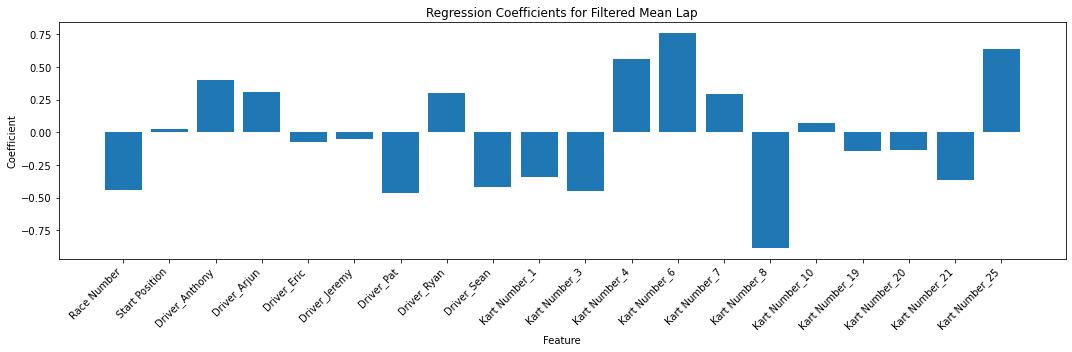

In [14]:
fig = plt.figure(figsize=(15,5))
plt.bar(reg_coef[0], reg_coef[1])
title = 'Regression Coefficients for ' + y_column
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('blog images/' + title + '.png')
plt.show()

In [15]:
reg_coef[reg_coef[0].str.contains('Driver')].sort_values(by=1, ascending=True)

,0,1
6,Driver_Pat,-0.461777
8,Driver_Sean,-0.418881
4,Driver_Eric,-0.077798
5,Driver_Jeremy,-0.055009
7,Driver_Ryan,0.30148
3,Driver_Arjun,0.307413
2,Driver_Anthony,0.404571


### ANCOVA

In [16]:
from pingouin import ancova
drivers = df['Driver'].unique()
driver_dictionary = dict(zip(drivers, range(len(drivers))))
df.replace(driver_dictionary, inplace=True)
ancova_results = ancova(data=df.drop(columns='Fastest Lap'), dv='Mean Lap', covar=['Start Position', 'Race Number', 'Driver'], between='Kart Number')

In [17]:
ancova_results

,Source,SS,DF,F,p-unc,np2
0,Kart Number,4.272200,10,0.079513,0.999843,0.053742
1,Start Position,2.356169,1,0.438521,0.518590,0.030372
2,Race Number,44.490973,1,8.280493,0.012169,0.371648
3,Driver,0.038996,1,0.007258,0.933315,0.000518
4,Residual,75.221808,14,NaN,NaN,NaN
